In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
def create_cityscapes_label_colormap():
    """Creates a label colormap used in CITYSCAPES segmentation benchmark."""
    colormap = np.zeros((256, 3), dtype=np.uint8)
    colormap[0] = [128, 64, 128]   # road
    colormap[1] = [244, 35, 232]   # sidewalk
    colormap[2] = [70, 70, 70]     # building
    colormap[3] = [102, 102, 156]  # wall
    colormap[4] = [190, 153, 153]  # fence
    colormap[5] = [153, 153, 153]  # pole
    colormap[6] = [250, 170, 30]   # traffic light
    colormap[7] = [220, 220, 0]    # traffic sign
    colormap[8] = [107, 142, 35]   # vegetation
    colormap[9] = [152, 251, 152]  # terrain
    colormap[10] = [70, 130, 180]  # sky
    colormap[11] = [220, 20, 60]   # person
    colormap[12] = [255, 0, 0]     # rider
    colormap[13] = [0, 0, 142]     # car
    colormap[14] = [0, 0, 70]      # truck
    colormap[15] = [0, 60, 100]    # bus
    colormap[16] = [0, 80, 100]    # train
    colormap[17] = [0, 0, 230]     # motorcycle
    colormap[18] = [119, 11, 32]   # bicycle
    return colormap

# Class names for the Cityscapes dataset
LABEL_NAMES = np.asarray([
    'road',
    'sidewalk',
    'building',
    'wall',
    'fence',
    'pole',
    'traffic light',
    'traffic sign',
    'vegetation',
    'terrain',
    'sky',
    'person',
    'rider',
    'car',
    'truck',
    'bus',
    'train',
    'motorcycle',
    'bicycle',
])

In [3]:
def find_unique_colors_from_viz(instance_image): # Helper function (same as before)
    """Finds unique non-black colors in an RGB image."""
    pixels = instance_image.reshape(-1, 3)
    unique_colors_array = np.unique(pixels, axis=0)
    # Filter out black color [0, 0, 0]
    result= unique_colors_array[~np.all(unique_colors_array == [0, 0, 0], axis=1)]
    print(f"Unique colors found: {result}")
    return result

def decode_segmentation_map(instance_image, colormap):
    """
    Decode RGB segmentation image back to class IDs map.
    Supports extra instance-level colors not in colormap.
    
    Args:
        instance_image: RGB image with instance-level colors (H2, W2, 3)
        segmentation_image: RGB segmentation image (H, W, 3)
        colormap: Colormap used for segmentation (256, 3)
    
    Returns:
        segmentation_map: 2D array with class IDs (H, W)
    """
    height, width = instance_image.shape[:2]
    # Step 1: Initialize segmentation map
    segmentation_map = np.zeros((height, width), dtype=np.uint8)


    # Step 2: Handle instance-level info

    unique_colors = find_unique_colors_from_viz(instance_image)
    color_to_class_id = {tuple(color): idx  for idx, color in enumerate(unique_colors)}
    # Step 3: Map colors to class IDs
    for color in unique_colors:
        new_mask = np.all(instance_image == color.reshape(1, 1, 3), axis=2)
        segmentation_map[new_mask] = color_to_class_id[tuple(color)]

    return segmentation_map

def reverse_inferno_colormap(depth_color_image_rgb, 
                                    explicit_missing_marker_rgb=None,
                                    no_lidar_return_bkg_rgb=[252,255,164],
                                    color_match_threshold_sq=100):
    """
    Robustly converts an inferno-colored RGB depth image back to a 2D numerical depth map.
    - Decoded inferno colors are mapped to [0.0, 1.0].
    - Explicit "missing" marker colors are mapped to np.nan.
    - "No Lidar return" background colors are mapped to np.nan.
    - Other pixel colors not closely matching the inferno colormap are also mapped to np.nan.

    Args:
        depth_color_image_rgb: RGB depth image (H, W, 3) as a NumPy array.
        explicit_missing_marker_rgb: A list/tuple [R, G, B] for a color that *explicitly*
                                     marks missing data in the PNG (e.g., your specific yellow).
                                     If None, this check is skipped.
        no_lidar_return_bkg_rgb: A list/tuple [R, G, B] for the color representing
                                 "no Lidar return" background in the PNG (e.g., pale yellow).
                                 If None, this specific check is skipped, relying on distance.
        color_match_threshold_sq: Maximum squared Euclidean distance for a pixel color
                                  to be considered a valid match to an inferno color.
                                  Tune this value carefully. Lower is stricter.
    
    Returns:
        2D depth map (np.float32) where missing/invalid pixels are np.nan,
        and valid depths are in the range [0.0, 1.0].
    """
    
    # Ensure input is RGB
    if depth_color_image_rgb.shape[2] != 3:
        raise ValueError("Input image must be an RGB image (3 channels).")

    # --- Reference Inferno Colormap ---
    x_ref = np.arange(256)
    inferno_ref_colors = (plt.cm.inferno(x_ref)[:, :3] * 255).astype(np.uint8) # (256, 3) uint8

    height, width = depth_color_image_rgb.shape[:2]
    # Initialize with np.nan. Pixels will only get a numerical value if matched.
    depth_map_out = np.full((height, width), np.nan, dtype=np.float32)

    # --- Prepare explicit marker colors if provided ---
    if explicit_missing_marker_rgb is not None:
        missing_marker_color_np = np.array(explicit_missing_marker_rgb, dtype=np.uint8)
    else:
        missing_marker_color_np = None

    if no_lidar_return_bkg_rgb is not None:
        no_return_bkg_color_np = np.array(no_lidar_return_bkg_rgb, dtype=np.uint8)
    else:
        no_return_bkg_color_np = None

    # --- Process each pixel ---
    for r in range(height):
        for c in range(width):
            pixel_rgb = depth_color_image_rgb[r, c]

            # 1. Check for explicit "missing data" marker color
            if missing_marker_color_np is not None and np.array_equal(pixel_rgb, missing_marker_color_np):
                depth_map_out[r, c] = np.nan # Already initialized to nan, but explicit
                continue

            # 2. Check for "no Lidar return" background color
            if no_return_bkg_color_np is not None and np.array_equal(pixel_rgb, no_return_bkg_color_np):
                depth_map_out[r, c] = np.nan # Already initialized to nan, but explicit
                continue

            # 3. Find closest match in the inferno colormap
            # Cast pixel_rgb to int32 before subtraction to avoid uint8 overflow/wrap-around
            distances_sq = np.sum((inferno_ref_colors - pixel_rgb.astype(np.int32))**2, axis=1)
            closest_idx = np.argmin(distances_sq)
            
            # 4. If the match is too poor (distance too high), consider it missing (NaN)
            if distances_sq[closest_idx] > color_match_threshold_sq:
                depth_map_out[r, c] = np.nan # Already initialized to nan
            else:
                # It's a valid inferno color (or close enough)
                # Normalize index (0-255) to depth value (0.0-1.0)
                depth_map_out[r, c] = closest_idx / 255.0
                                   
    return depth_map_out

In [4]:
def resize_segmentation(instance_image, segmentation_image, target_height, target_width):
    """
    Resize segmentation image while preserving class labels
    
    Args:
        segmentation_image: RGB segmentation image (H, W, 3)
        target_height: Target height
        target_width: Target width
    
    Returns:
        Resized RGB segmentation image (target_height, target_width, 3)
    """
    # Get colormap for decoding and encoding
    colormap = create_cityscapes_label_colormap()
    
    # Decode to class IDs
    
    #resizing instance image
    instance_image = cv2.resize(
        instance_image, 
        (target_width, target_height), 
        interpolation=cv2.INTER_NEAREST
    )

    
   

    print(f"Resized instance image shape: {instance_image.shape}")
    
    
    return  instance_image

In [16]:
from sklearn.neighbors import KNeighborsRegressor 
def fill_missing_depths(depth_map, segmentation_map, method='mean', 
                        min_component_size=1000, max_component_size=90000, 
                        neighbor_search_radius=5):
    """
    Fill missing depth values in connected components (of a specific size range) 
    within each class, using the mean/median of valid neighboring pixels 
    of the SAME CLASS around that component.

    Args:
        depth_map: 2D depth map with NaN for missing values (H, W)
        segmentation_map: 2D segmentation map with class IDs (H, W)
        method: Filling method ('median' or 'mean') for local neighborhood.
        min_component_size: Min area of a missing component to fill.
        max_component_size: Max area of a missing component to fill.
        neighbor_search_radius: How many pixels out from the component boundary 
                                to look for valid neighbors. A radius of 1 means 
                                immediate 8-connected neighbors.
    
    Returns:
        Filled depth map (H, W)
    """
    filled_depth = depth_map.copy()
    unique_classes = np.unique(segmentation_map)
    height, width = depth_map.shape

    # print(f"Fill missing depths (method: {method}): Min component size: {min_component_size}, Max: {max_component_size}, Radius: {neighbor_search_radius}")

    for class_id in unique_classes:
        class_mask_original = (segmentation_map == class_id) # Mask for the entire class area
        
        # Identify missing pixels ONLY within the current class
        missing_pixels_in_class_mask = np.logical_and(class_mask_original, np.isnan(depth_map))
        
        if not np.any(missing_pixels_in_class_mask): # No missing pixels in this class
            # print(f"  Class {class_id}: No missing pixels to fill.")
            continue

        # Find connected components of missing pixels within this class
        # cv2.connectedComponentsWithStats requires uint8 input
        num_labels, labels_map, stats, _ = cv2.connectedComponentsWithStats(
            missing_pixels_in_class_mask.astype(np.uint8), 
            connectivity=8,  # Consider 8-connectivity
            ltype=cv2.CV_32S
        )
        
        # print(f"  Class {class_id}: Found {num_labels - 1} connected components of missing pixels.")
        filled_component_count = 0

        for label_idx in range(1, num_labels): # Label 0 is the background (non-missing pixels in this mask), so skip it
            component_area = stats[label_idx, cv2.CC_STAT_AREA]
            
            #if not (min_component_size <= component_area <= max_component_size):
                # print(f"    Component {label_idx} (Area: {component_area}): Skipped (size criteria not met).")
             #   continue # Skip components outside the desired size range

            current_component_mask = (labels_map == label_idx)

            # Find neighbors of this component
            # Dilate the component mask to find potential neighbors
            kernel_size = 2 * neighbor_search_radius + 1
            kernel = np.ones((kernel_size, kernel_size), np.uint8)
            # Ensure current_component_mask is uint8 for dilate
            dilated_component_mask_uint8 = cv2.dilate(current_component_mask.astype(np.uint8), kernel, iterations=1)
            dilated_component_mask = dilated_component_mask_uint8.astype(bool)
            
            # Neighbor mask excludes the component itself
            neighbor_mask_boundary = np.logical_and(dilated_component_mask, ~current_component_mask)
            
            # Consider only neighbors that are:
            # 1. Within the image bounds (implicitly handled by array indexing)
            # 2. Part of the SAME class_id (using class_mask_original)
            # 3. Have VALID depth values (not NaN in the original depth_map)
            valid_neighbors_in_same_class_mask = np.logical_and.reduce((
                neighbor_mask_boundary,
                class_mask_original,    # Ensures neighbors are of the same class
                ~np.isnan(depth_map) # Ensures neighbors have valid depth in original map
            ))

            valid_neighbor_depths = depth_map[valid_neighbors_in_same_class_mask]

            if len(valid_neighbor_depths) > 0:
                if method == 'median':
                    fill_value = np.median(valid_neighbor_depths)
                elif method == 'mean':
                    fill_value = np.mean(valid_neighbor_depths)
                else: # Default to median for any other method string passed
                    # print(f"    Component {label_idx}: Unknown method '{method}'. Defaulting to local median.")
                    fill_value = np.median(valid_neighbor_depths)
                
                # Fill all pixels in this component with the calculated local fill_value
                filled_depth[current_component_mask] = fill_value
                filled_component_count +=1
                # print(f"    Component {label_idx} (Area: {component_area}): Filled with {fill_value:.4f} from {len(valid_neighbor_depths)} neighbors.")
            # else:
                # print(f"    Component {label_idx} (Area: {component_area}): No valid same-class neighbors found. Remains NaN.")
                
        # if filled_component_count > 0:
            # print(f"  Class {class_id}: Filled {filled_component_count} components matching size criteria using local stats.")
            
    return filled_depth

def gaussian_fill_missing_depths(depth_map, segmentation_map, sigma=1.0):
    """
    Fill missing depth values using Gaussian-weighted class values
    
    Args:
        depth_map: 2D depth map with NaN for missing values (H, W)
        segmentation_map: 2D segmentation map with class IDs (H, W)
        sigma: Sigma for Gaussian kernel
    
    Returns:
        Filled depth map (H, W)
    """
    filled_depth = depth_map.copy()
    height, width = depth_map.shape
    
    # Identify missing value positions
    missing_mask = np.isnan(depth_map)
    missing_positions = np.where(missing_mask)
    
    # For each missing position
    for i, j in zip(*missing_positions):
        class_id = segmentation_map[i, j]
        
        # Create local window
        window_size = int(sigma * 6) # 3-sigma rule (both sides)
        window_size = max(3, window_size) # Minimum window size of 3
        half_size = window_size // 2
        
        # Define window boundaries
        i_start = max(0, i - half_size)
        i_end = min(height, i + half_size + 1)
        j_start = max(0, j - half_size)
        j_end = min(width, j + half_size + 1)
        
        # Get window for the same class
        window_mask = np.logical_and(
            segmentation_map[i_start:i_end, j_start:j_end] == class_id,
            ~np.isnan(depth_map[i_start:i_end, j_start:j_end])
        )
        
        valid_depths = depth_map[i_start:i_end, j_start:j_end][window_mask]
        
        # If no valid depths in window, try whole image for this class
        if len(valid_depths) == 0:
            class_mask = np.logical_and(segmentation_map == class_id, ~np.isnan(depth_map))
            valid_depths = depth_map[class_mask]
            
            # If still no valid depths, use median of all valid depths
            if len(valid_depths) == 0:
                valid_depths = depth_map[~np.isnan(depth_map)]
                
                # If somehow still no valid depths, use a default value
                if len(valid_depths) == 0:
                    filled_depth[i, j] = 0.5  # Default middle value
                    continue
        
        # Fill with median of valid depths
        filled_depth[i, j] = np.median(valid_depths)
    
    return filled_depth

def knn_fill_missing_depths(depth_map, segmentation_map, k=50):
    """
    Fill missing depth values using K-Nearest Neighbors (KNN) based on segmentation classes.
    Uses sklearn.neighbors.KNeighborsRegressor for efficiency.

    Args:
        depth_map: 2D depth map with NaN for missing values (H, W)
        segmentation_map: 2D segmentation map with class IDs (H, W)
        k: Number of nearest neighbors to consider

    Returns:
        Filled depth map (H, W)
    """
    filled_depth = depth_map.copy()
    height, width = depth_map.shape

    # Identify valid (non-NaN) pixels to use for training KNN regressors
    valid_mask = ~np.isnan(depth_map)
    valid_positions_all = np.array(np.where(valid_mask)).T  # Shape: (n_valid, 2)
    valid_depths_all = depth_map[valid_mask]               # Shape: (n_valid,)

    # Identify missing pixels that need filling
    missing_mask = np.isnan(depth_map)
    missing_positions = np.array(np.where(missing_mask)).T # Shape: (n_missing, 2)

    if len(valid_positions_all) == 0:
        print("KNN Warning: No valid pixels found in the depth map. Returning original depth map.")
        return filled_depth  # No valid data to learn from, return as is (all NaNs)
    if len(missing_positions) == 0:
        print("KNN Info: No missing pixels to fill.")
        return filled_depth # No missing data to fill

    # Create regressors for each class that has at least one valid data point
    regressors_by_class = {}
    unique_classes_with_valid_data = np.unique(segmentation_map[valid_mask])

    for class_id in unique_classes_with_valid_data:
        # Get valid positions and depths for the current class
        class_points_mask_on_valid = (segmentation_map[valid_mask] == class_id)
        current_class_positions = valid_positions_all[class_points_mask_on_valid]
        current_class_depths = valid_depths_all[class_points_mask_on_valid]

        if len(current_class_positions) >=50:        # Arbitrary threshold for KNN training
            # KNeighborsRegressor automatical-ly uses min(k, n_samples_fit) for n_neighbors
            # However, n_neighbors must be > 0 for fit.
            actual_k_class = min(k, len(current_class_positions))
            actual_k_class = k # added for testing purposes
            if actual_k_class == 0: # Should not happen if len(current_class_positions) > 0
                actual_k_class = 1 
            
            knn = KNeighborsRegressor(n_neighbors=actual_k_class, weights='uniform',)
            knn.fit(current_class_positions, current_class_depths)
            regressors_by_class[class_id] = knn

    # Create a fallback regressor using all valid data points
    knn_fallback = None
    
    actual_k_fallback = min(k, len(valid_positions_all))
    if actual_k_fallback > 0:
        knn_fallback = KNeighborsRegressor(n_neighbors=actual_k_fallback, weights='uniform')
        knn_fallback.fit(valid_positions_all, valid_depths_all)
    
    # Iterate through missing positions and fill them
    # Batch predictions for efficiency if many missing pixels share the same class
    
    unique_classes_in_missing = np.unique(segmentation_map[missing_mask])
    
    for class_id_of_missing in unique_classes_in_missing:
        # Get all missing positions for the current class_id
        current_class_missing_mask_on_original = np.logical_and(missing_mask, segmentation_map == class_id_of_missing)
        positions_to_predict_for_class = np.array(np.where(current_class_missing_mask_on_original)).T
        
        if len(positions_to_predict_for_class) == 0:
            continue

        regressor = regressors_by_class.get(class_id_of_missing)
        
        if regressor:
            # Use the regressor specific to this class if available
            predicted_depths = regressor.predict(positions_to_predict_for_class)
            for idx, (r, c) in enumerate(positions_to_predict_for_class):
                filled_depth[r, c] = predicted_depths[idx]
        elif knn_fallback:
            # Fallback: class_id_of_missing had no valid data points.
            # Use the regressor trained on all valid points.
            predicted_depths = knn_fallback.predict(positions_to_predict_for_class)
            for idx, (r, c) in enumerate(positions_to_predict_for_class):
                filled_depth[r, c] = predicted_depths[idx]
        else:
            # This case is hit if len(valid_positions_all) == 0 or k=0 for fallback
            # which should be handled at the start.
            # If somehow reached, leave as NaN or use a global default.
            # For now, we'll leave them as NaN, as there's no basis for prediction.
            pass # filled_depth for these positions remains NaN

    return filled_depth


In [6]:
import hdbscan

def hdbscan_fill_missing_depths(depth_map, segmentation_map, min_cluster_size=10):
    """
    Fill missing depth values using HDBSCAN clustering within each segmentation class.
    
    Args:
        depth_map: 2D depth map with NaN for missing values (H, W)
        segmentation_map: 2D segmentation map with class IDs (H, W)
        min_cluster_size: Minimum cluster size for HDBSCAN
    
    Returns:
        Filled depth map (H, W)
    """
    filled_depth = depth_map.copy()
    height, width = depth_map.shape
    unique_classes = np.unique(segmentation_map)
    
    for class_id in unique_classes:
        class_mask = (segmentation_map == class_id)
        valid_mask = np.logical_and(class_mask, ~np.isnan(depth_map))
        missing_mask = np.logical_and(class_mask, np.isnan(depth_map))
        
        if np.sum(valid_mask) < min_cluster_size:
            # Not enough points for clustering, fallback to mean
            fill_value = np.nanmean(depth_map[valid_mask]) if np.sum(valid_mask) > 0 else 0
            filled_depth[missing_mask] = fill_value
            continue
        
        # Prepare data for clustering
        valid_indices = np.array(np.where(valid_mask)).T
        valid_depths = depth_map[valid_mask]
        
        # Cluster valid points
        clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
        labels = clusterer.fit_predict(valid_indices)
        
        # Compute mean depth for each cluster
        cluster_means = {}
        for lbl in np.unique(labels):
            if lbl == -1:
                continue  # Ignore noise
            cluster_means[lbl] = np.mean(valid_depths[labels == lbl])
        
        # Fill missing pixels by nearest cluster mean
        missing_indices = np.array(np.where(missing_mask)).T
        if len(missing_indices) == 0 or len(cluster_means) == 0:
            continue
        
        cluster_centers = np.array([valid_indices[labels == lbl].mean(axis=0) for lbl in cluster_means.keys()])
        cluster_labels = list(cluster_means.keys())
        
        for idx, (i, j) in enumerate(missing_indices):
            # Find nearest cluster center
            dists = np.linalg.norm(cluster_centers - np.array([i, j]), axis=1)
            nearest = np.argmin(dists)
            fill_value = cluster_means[cluster_labels[nearest]]
            filled_depth[i, j] = fill_value
    
    return filled_depth

In [7]:
#INTERPOLATION
from scipy.interpolate import griddata
def interpolation_fill_missing_depths(depth_map, segmentation_map, method='linear'):
    """
    Fill missing depth values using interpolation (linear, nearest, cubic)
    on a per-class basis.

    Args:
        depth_map: 2D depth map with NaN for missing values (H, W)
        segmentation_map: 2D segmentation map with class IDs (H, W)
        method: Interpolation method to use ('linear', 'nearest', 'cubic').

    Returns:
        Filled depth map (H, W)
    """
    filled_depth = depth_map.copy()
    unique_classes = np.unique(segmentation_map)
    height, width = depth_map.shape

    min_points_for_interp = 3 if method == 'linear' else (4 if method == 'cubic' else 1)

    for class_id in unique_classes:
        class_mask = (segmentation_map == class_id)

        # Valid points within the current class
        valid_in_class_mask = np.logical_and(class_mask, ~np.isnan(depth_map))
        valid_positions_class = np.array(np.where(valid_in_class_mask)).T
        valid_depths_class = depth_map[valid_in_class_mask]

        if len(valid_positions_class) < min_points_for_interp:
            # print(f"Class {class_id}: Too few valid points ({len(valid_positions_class)}) for '{method}' interpolation. Skipping.")
            # Optionally, you could fall back to class mean/median here if desired
            # For now, we'll leave these missing pixels as NaN
            if len(valid_positions_class) > 0: # If there's at least one point, fill with its value for very small components
                missing_for_class_current = np.logical_and(class_mask, np.isnan(filled_depth))
                if np.any(missing_for_class_current):
                    fill_val_simple = np.nanmean(valid_depths_class) if method != 'median' else np.nanmedian(valid_depths_class)
                    if not np.isnan(fill_val_simple):
                         filled_depth[missing_for_class_current] = fill_val_simple
            continue

        # Missing points within the current class
        missing_in_class_mask = np.logical_and(class_mask, np.isnan(filled_depth)) # Use filled_depth to check if already filled by a previous step/class
        if not np.any(missing_in_class_mask): # No missing pixels to fill in this class
            continue
        
        missing_positions_class = np.array(np.where(missing_in_class_mask)).T
        
        if len(missing_positions_class) == 0: # Double check
            continue

        # Perform interpolation
        try:
            interpolated_depths = griddata(
                valid_positions_class,      # Known points coordinates
                valid_depths_class,         # Known points values
                missing_positions_class,    # Points to interpolate
                method=method,
                fill_value=np.nan           # Fill with NaN if outside convex hull or other issues
            )
        except Exception as e:
            # print(f"Class {class_id}: Error during griddata interpolation: {e}. Skipping.")
            continue


        # Fill the missing values in the output map
        # Ensure we only fill where interpolation was successful (not NaN)
        valid_interpolated_mask = ~np.isnan(interpolated_depths)
        rows_to_fill = missing_positions_class[valid_interpolated_mask, 0]
        cols_to_fill = missing_positions_class[valid_interpolated_mask, 1]
        
        filled_depth[rows_to_fill, cols_to_fill] = interpolated_depths[valid_interpolated_mask]
        # print(f"Class {class_id}: Interpolated {np.sum(valid_interpolated_mask)} points.")

    return filled_depth

In [8]:
def analyze_depth_by_class(depth_map, segmentation_map):
    """
    Analyze depth statistics by semantic class
    
    Args:
        depth_map: 2D depth map (H, W)
        segmentation_map: 2D segmentation map with class IDs (H, W)
    
    Returns:
        Dictionary with class statistics
    """
    stats = {}
    
    # Get unique classes in segmentation
    unique_classes = np.unique(segmentation_map)
    
    for class_id in unique_classes:
        if class_id < len(LABEL_NAMES):
            class_name = LABEL_NAMES[class_id]
        else:
            class_name = f"Unknown-{class_id}"
            
        # Create mask for current class and get valid depths
        class_mask = (segmentation_map == class_id)
        valid_depths = depth_map[np.logical_and(class_mask, ~np.isnan(depth_map))]
        
        # Calculate stats
        if len(valid_depths) > 0:
            stats[class_name] = {
                'mean': float(np.mean(valid_depths)),
                'median': float(np.median(valid_depths)),
                'min': float(np.min(valid_depths)),
                'max': float(np.max(valid_depths)),
                'std': float(np.std(valid_depths)),
                'count': int(len(valid_depths)),
                'missing': int(np.sum(np.logical_and(class_mask, np.isnan(depth_map))))
            }
        else:
            stats[class_name] = {
                'mean': None,
                'median': None,
                'min': None,
                'max': None,
                'std': None,
                'count': 0,
                'missing': int(np.sum(class_mask))
            }
    
    return stats

import os

def visualize_results(original_image, original_depth, filled_depth, segmentation_map, colormap, output_dir="output"):
    """
    Visualize original depth, filled depth, and segmentation, and save the images to disk.
    
    Args:
        original_depth: Original depth map with NaNs (H, W)
        filled_depth: Filled depth map (H, W)
        segmentation_map: Segmentation map with class IDs (H, W)
        colormap: Colormap for visualization
        output_dir: Directory to save the output images
    """
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Create a copy of original_depth with a specific color for NaN values
    depth_viz = original_depth.copy()
    nan_mask = np.isnan(depth_viz)
    depth_viz = plt.cm.inferno(depth_viz)[:, :, :3]  # Apply inferno again
    
    # Make NaN values white for visualization
    depth_viz[nan_mask, 0] = 1.0  # Red channel
    depth_viz[nan_mask, 1] = 1.0  # Green channel
    depth_viz[nan_mask, 2] = 1.0  # Blue channel
    
    # Filled depth visualization
    filled_viz = plt.cm.inferno(filled_depth)[:, :, :3]
    
    # Segmentation visualization
    #seg_viz = np.zeros((*segmentation_map.shape, 3), dtype=np.uint8)
    #for class_id in np.unique(segmentation_map):
     #   mask = (segmentation_map == class_id)
      #  seg_viz[mask] = colormap[class_id]
    seg_viz=segmentation_map
    
    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    
    axes[0, 0].imshow(depth_viz)
    axes[0, 0].set_title('Original Depth (white = missing)')
    axes[0, 0].axis('off')
    plt.imsave(os.path.join(output_dir, "original_depth.png"), depth_viz)

    axes[0, 1].imshow(filled_depth,cmap='inferno')
    plt.imsave(os.path.join(output_dir, "filled_depth.png"), filled_depth, )
    plt.imsave(os.path.join(output_dir, "filled_depth_color.png"), filled_viz)

    axes[0, 1].set_title('Filled Depth')
    axes[0, 1].axis('off')

    axes[1, 0].imshow(seg_viz)
    axes[1, 0].set_title('Segmentation')
    axes[1, 0].axis('off')
    plt.imsave(os.path.join(output_dir, "segmentation.png"), seg_viz)

    # Plot depth difference
    diff = np.abs(filled_depth - original_depth)
    diff[nan_mask] = np.nanmax(diff)  # Show previously missing values as max difference
    diff_viz = plt.cm.viridis(diff / np.nanmax(diff))[:, :, :3]
    
    axes[1, 1].imshow(original_image)
    axes[1, 1].set_title('original image')
    axes[1, 1].axis('off')
    plt.imsave(os.path.join(output_dir, "depth_difference.png"), diff_viz)

    # Add legend for segmentation
    handles = []
    for i, label in enumerate(LABEL_NAMES):
        color_patch = plt.Rectangle((0, 0), 1, 1, color=[c/255 for c in colormap[i]])
        handles.append((color_patch, label))
    
    # Add legend outside the plots
    fig.subplots_adjust(bottom=0.2)
    legend_ax = fig.add_axes([0.1, 0.01, 0.8, 0.15])
    legend_ax.axis('off')
    
    # Create legend with 3 columns
    legend_elements = [patch for patch, _ in handles]
    legend_labels = [label for _, label in handles]
    legend = legend_ax.legend(legend_elements, legend_labels, 
                               loc='center', ncol=4, frameon=False)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "knn_50_detectron_uniform_weights.png"))
    plt.show()



In [9]:
def process_depth_with_segmentation(instance_image, original_image, depth_image_path, segmentation_image_path, method='median'):
    """
    Main function to process depth image using segmentation
    
    Args:
        depth_image_path: Path to depth image with inferno colormap
        segmentation_image_path: Path to segmentation image
        method: Filling method ('median', 'mean', or 'gaussian')
    
    Returns:
        Tuple of (original_depth, filled_depth, segmentation_map, stats)
    """
    # Load images
    depth_color_image = cv2.imread(depth_image_path)
    depth_color_image = cv2.cvtColor(depth_color_image, cv2.COLOR_BGR2RGB)
    
    segmentation_image = cv2.imread(segmentation_image_path)
    segmentation_image = cv2.cvtColor(segmentation_image, cv2.COLOR_BGR2RGB)

    # Load instance image
    instance_image = cv2.imread(instance_image)
    instance_image = cv2.cvtColor(instance_image, cv2.COLOR_BGR2RGB)
    
    # Get the cityscapes colormap
    colormap = create_cityscapes_label_colormap()
    
    # Ensure segmentation image has same dimensions as depth image
    depth_height, depth_width = depth_color_image.shape[:2]
    seg_height, seg_width = segmentation_image.shape[:2]
    # Resize instance image if needed to match dimensions
    #if instance_image.shape[0] != seg_height or instance_image.shape[1] != seg_width:
     #   print(f"Resizing instance image from {seg_height}x{seg_width} to {depth_height}x{depth_width}")
      #  instance_image = resize_segmentation(instance_image,segmentation_image, depth_height, depth_width)
    #
    if depth_height != seg_height or depth_width != seg_width:
        print(f"Resizing segmentation image from {seg_height}x{seg_width} to {depth_height}x{depth_width}")
        instance_image = resize_segmentation(instance_image, segmentation_image, depth_height, depth_width)
        # here to add resize instance segmentation image!!!!
    
    # Decode segmentation image to class IDs
    segmentation_map = decode_segmentation_map(instance_image, colormap)
    
    # Convert colored depth image back to depth map
    depth_map = reverse_inferno_colormap(depth_color_image)# careful it was depth_color_image!!!
    
    # Fill missing values based on method
    if method == 'gaussian':
        filled_depth = gaussian_fill_missing_depths(depth_map, segmentation_map)
    elif method == 'knn':
        filled_depth = knn_fill_missing_depths(depth_map, segmentation_map)
    elif method == 'linear_interp':
        print(f"Applying 'linear interpolation' method (per-class).")
        filled_depth = interpolation_fill_missing_depths(depth_map, segmentation_map, method='linear')
    elif method == 'cubic_interp':
        print(f"Applying 'cubic interpolation' method (per-class).")
        filled_depth = interpolation_fill_missing_depths(depth_map, segmentation_map, method='cubic')
    elif method == 'nearest_interp':
        print(f"Applying 'nearest neighbor interpolation' method (per-class).")
        filled_depth = interpolation_fill_missing_depths(depth_map, segmentation_map, method='nearest')
    elif method == 'hdbscan':
        print(f"Applying 'HDBSCAN' method (per-class).")
        filled_depth = hdbscan_fill_missing_depths(depth_map, segmentation_map)
    else:
         
         filled_depth = fill_missing_depths(depth_map, segmentation_map, method)

    # Analyze depth by class
    stats = analyze_depth_by_class(depth_map, segmentation_map)
    
    # Visualize results
    visualize_results(original_image, depth_map, filled_depth, segmentation_map, colormap)
    
    # Calculate completion rate
    total_pixels = depth_map.size
    missing_before = np.sum(np.isnan(depth_map))
    missing_after = np.sum(np.isnan(filled_depth))
    completion_rate = ((missing_before - missing_after) / missing_before) * 100 if missing_before > 0 else 100
    
    print(f"Depth map completion statistics:")
    print(f"  Total pixels: {total_pixels}")
    print(f"  Missing pixels before: {missing_before} ({missing_before/total_pixels*100:.2f}%)")
    print(f"  Missing pixels after: {missing_after} ({missing_after/total_pixels*100:.2f}%)")
    print(f"  Completion rate: {completion_rate:.2f}%")
    
    return depth_map, filled_depth, segmentation_map, stats



Processing with KNN method
Unique colors found: [[  0   1   1]
 [  0   2   2]
 [  0   3   3]
 ...
 [254  31  13]
 [255   3  20]
 [255  55  17]]


<ipython-input-3-89a08c066457>:35: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 256 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  segmentation_map[new_mask] = color_to_class_id[tuple(color)]
<ipython-input-3-89a08c066457>:35: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 257 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  segmentation_map[new_mask] = color_to_class_id[tuple(color)]
<ipython-input-3-89a08c066457>:35: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 258 to uint8 will fail in the future.
For the old behavior, usually:
    np.array

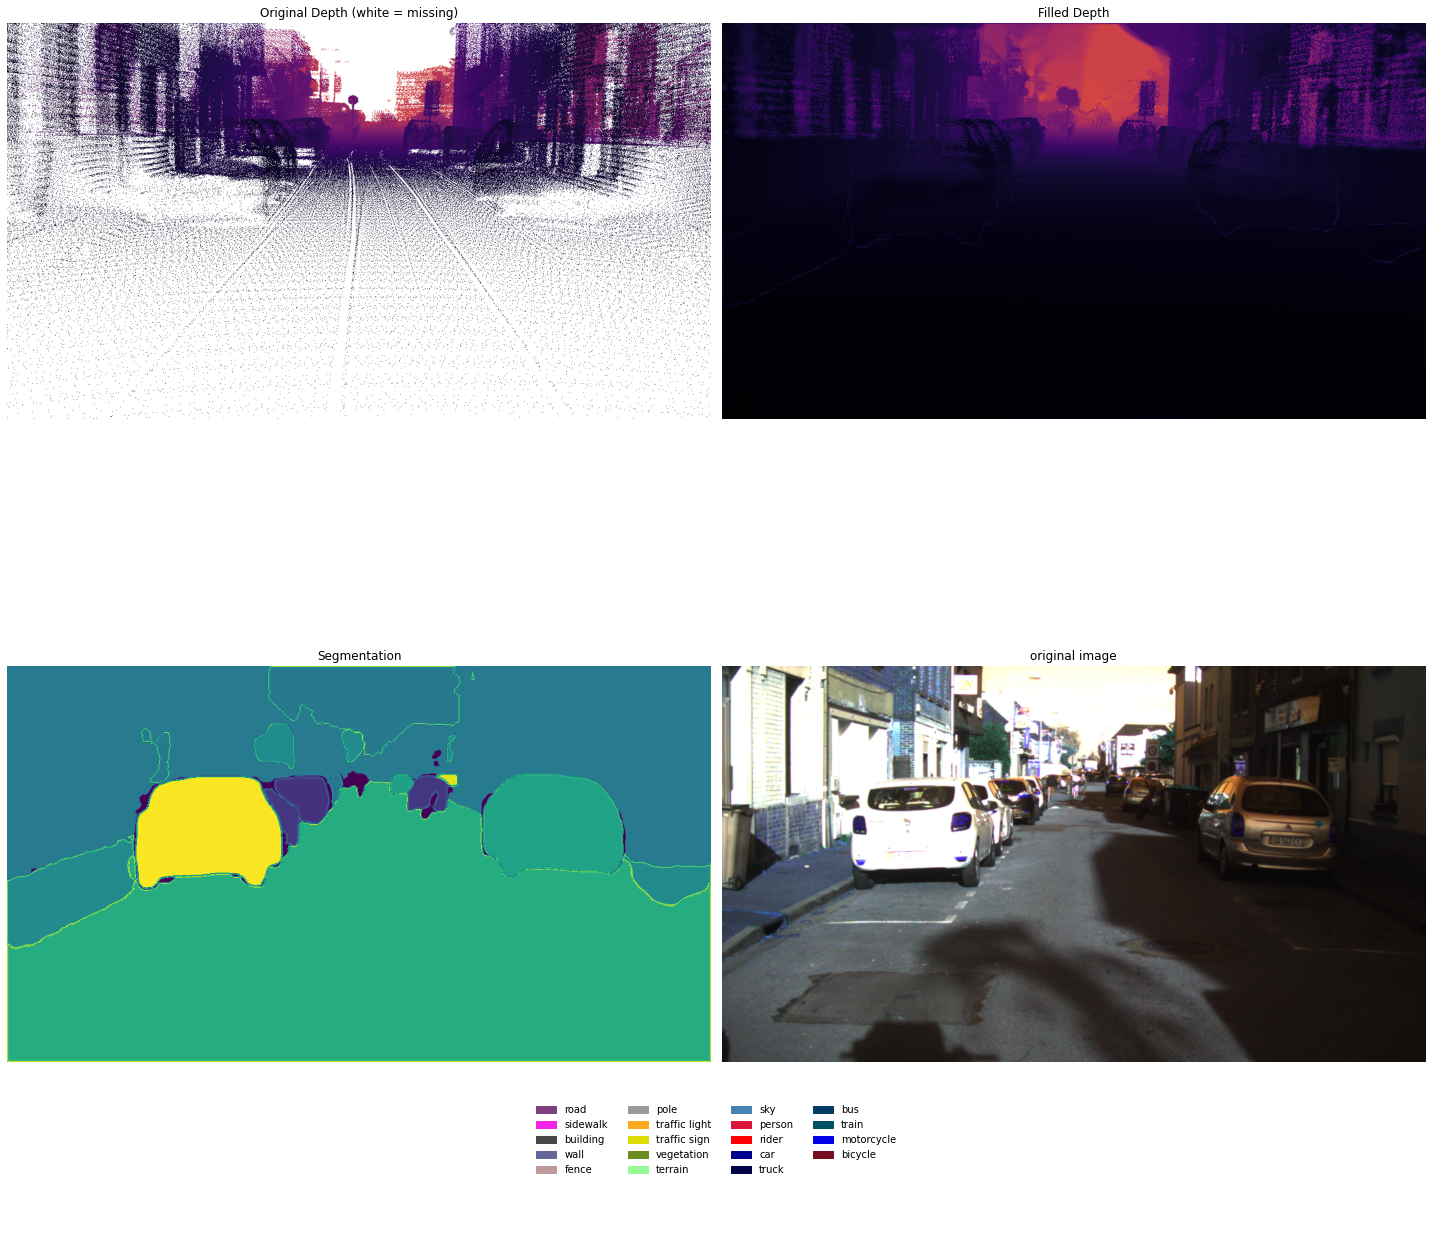

Depth map completion statistics:
  Total pixels: 921600
  Missing pixels before: 644098 (69.89%)
  Missing pixels after: 0 (0.00%)
  Completion rate: 100.00%

Depth statistics by class (method: knn):
Class: road
  mean: 0.17897428572177887
  median: 0.16862745583057404
  min: 0.0470588244497776
  max: 0.5411764979362488
  std: 0.09031067043542862
  count: 3153
  missing: 1300
--------------------------------------------------
Class: sidewalk
  mean: 0.2689075767993927
  median: 0.0941176488995552
  min: 0.0470588244497776
  max: 0.5411764979362488
  std: 0.23617815971374512
  count: 7
  missing: 19
--------------------------------------------------
Class: building
  mean: 0.13737022876739502
  median: 0.08235294371843338
  min: 0.07450980693101883
  max: 0.37254902720451355
  std: 0.09584858268499374
  count: 34
  missing: 51
--------------------------------------------------
Class: wall
  mean: 0.14684097468852997
  median: 0.11568627506494522
  min: 0.08235294371843338
  max: 0.32156

In [17]:
instance_image_path = "./seg/inst_800.png"
depth_image_path = "./res/800.png"
segmentation_image_path = "./seg/inst_800.png"
original_image = cv2.imread('./images/800.png')

# Test different filling methods
methods = ['median', 'mean', 'gaussian', 'knn','linear_interp', 'cubic_interp', 'nearest_interp', 'hdbscan']
methods=['knn']
results = {}

for method in methods:
        print(f"\n{'='*80}\nProcessing with {method.upper()} method\n{'='*80}")
        
        # Process with current method
        depth_map, filled_depth, segmentation_map, stats = process_depth_with_segmentation(instance_image_path, original_image,
            depth_image_path, segmentation_image_path, method=method
        )
        
        # Store results
        results[method] = {
            'filled_depth': filled_depth,
            'stats': stats
        }
        
        # Print statistics for each class
        print(f"\nDepth statistics by class (method: {method}):")
        for class_name, class_stats in stats.items():
            print(f"Class: {class_name}")
            for stat_name, stat_value in class_stats.items():
                print(f"  {stat_name}: {stat_value}")
            print("-" * 50)
        
        # Save filled depth map
        #plt.imsave(f"filled_depth_{method}.png", filled_depth, cmap='inferno')
        
    # Compare methods
print("\n\nComparison of filling methods:")
print(f"{'Class':<20} {'Method':<10} {'Mean':<10} {'Median':<10} {'Std':<10}")
print("-" * 60)

# Get unique class names across all methods
all_classes = set()
for method_stats in [results[method]['stats'] for method in methods]:
        all_classes.update(method_stats.keys())
    
    # Compare statistics for each class
for class_name in sorted(all_classes):
        print(f"{class_name:<20}")
        for method in methods:
            if class_name in results[method]['stats']:
                stats = results[method]['stats'][class_name]
                mean_val = stats['mean'] if stats['mean'] is not None else 'N/A'
                median_val = stats['median'] if stats['median'] is not None else 'N/A'
                std_val = stats['std'] if stats['std'] is not None else 'N/A'
                
                if isinstance(mean_val, float):
                    mean_val = f"{mean_val:.4f}"
                if isinstance(median_val, float):
                    median_val = f"{median_val:.4f}"
                if isinstance(std_val, float):
                    std_val = f"{std_val:.4f}"
                    
                print(f"{'':<20} {method:<10} {mean_val:<10} {median_val:<10} {std_val:<10}")
        print("-" * 60)